In [3]:
import datetime as dt
import numpy as np
import SEB_functions as SEBf
import matplotlib.pyplot as plt
import pandas as pd

from scipy.constants import Stefan_Boltzmann as SIGMA


In [4]:
SEBdata = SEBf.SEB_data(FileName="PKM-data/S10_SEB_2009_2019.txt")

The header has  88 entries.
AWS file 'S10_SEB_2009_2019.txt' has 91776 lines of data for 84 variables, start reading it.
Reading completed.
No data corrections needed for this station.


In [31]:
SIGMA=5.67e-8

In [238]:
class CloseSEB():
    def __init__(self, SEBdata):
        self.T_air = SEBdata.Extract_Variable("Tair") + 273.15 # in degK
        self.T_surface = SEBdata.Extract_Variable("Tsurf_calc") + 273.15
        self.T2m = SEBdata.Extract_Variable("Tair_2m") + 273.15 # in degK
        self.P = SEBdata.Extract_Variable("pres")
        self.U10 = SEBdata.Extract_Variable("FF_10m")
        self.RH = SEBdata.Extract_Variable("RH")/100 # from % to fraction
        self.SHF_initial = SEBdata.Extract_Variable("Hsen")
        self.G = SEBdata.Extract_Variable("Gs")
        self.SWdown = SEBdata.Extract_Variable("SWin_corr")
        self.SWup = SEBdata.Extract_Variable("SWout")
        self.SWnet = SEBdata.Extract_Variable("SWnet_corr")
        self.LWup = SEBdata.Extract_Variable("LWout_corr")
        self.LWdown = SEBdata.Extract_Variable("LWin")
        self.LWnet_model = SEBdata.Extract_Variable('LWnet_model')
        self.LHF_initial = SEBdata.Extract_Variable("Hlat")
        self.melt_initial= SEBdata.Extract_Variable("melt_energy")
        self.res_initial = SEBdata.Extract_Variable("rest_energy")
        #Find constants
        self.c_tbd = self.find_ctbd()
        self.epsilon = self.find_epsi()
        # TODO: how do we handle nan values?

    def find_ctbd(self):
        '''Function to calculate infamous c_tbd'''
        SHF = self.SHF_initial
        T_air2m = self.T2m
        T_surf = self.T_surface
        c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))
        c_tbd = np.array(c_tbd)
        c_tbd[c_tbd < 0] = 0
        c_tbd[c_tbd > 25] = 25
        c_tbd[c_tbd == np.nan] = 0

        self.c_tbd = c_tbd
        return c_tbd
    
    def find_alpha(self, SEBdata):
        cl_arr = []
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol
        for (T, RH, P, U10, LHF_init) in zip(self.T_air, self.RH, self.P, self.U10, self.LHF_initial):
            if T <= 273.15:
                c_1 = 22.587
                c_2 = 273.68 #in C
            elif T > 273.15:
                c_1 = 17.502
                c_2 = 240.97 #in C
            else:
                c_1 = 17.502
                c_2 = 240.97 #in C
            Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in % 
            cl = LHF_init/(U10*(Qsat*(RH-1)))
            cl_arr.append(cl)

        cl_arr = np.array(cl_arr)
        cl_mask = ~np.isnan(cl_arr)
        cl_arr = cl_arr[cl_mask]
    
        cl_arr[cl_arr < -1000] = -1000
        cl_arr[cl_arr > 2500] = 2500
         
        c_tbd = self.c_tbd
        c_tbd = c_tbd[cl_mask]

        plt.scatter(cl_arr, c_tbd)
        plt.xlabel('cl')
        plt.ylabel('c_tbd')
        alpha = np.polyfit(c_tbd,cl_arr,1)
        return alpha[0]
    
    def find_epsi(self):
        epsilon = self.LWdown/(SIGMA*(self.T2m**4))
        self.epsilon = epsilon
        return epsilon

    def print_var(self, var):
        '''easy return of variable'''
        return getattr(self, var)

    def LWadjdown(self, Tatm, dT):
        '''Function to convert temperature anomaly to LW down in W/m2'''
        LW_adj_down = SEBf.convert_T_in_LWout(Tatm + dT, Celcius=False)*-1 
        return LW_adj_down
    
    def find_LHF(self,T, P, U10, RH,c_tbd):
        '''Function to calculate the latent heat flux from the 2m temperature, pressure, relative humidity and wind speed'''
        # TODO: which Temperature needed?
        mv = 18.0153 #g/mol
        mair = 28.9644 #g/mol

        if T <= 273.15:
            c_1 = 22.587
            c_2 = 273.68 #in C
        elif T > 273.15:
            c_1 = 17.502
            c_2 = 240.97 #in C
        else:
            return np.nan
        
        cs = 260*c_tbd #TODO check if cl is one <-- apparently proportional to cs?! --> set same as c_tbd
        Qsat = 6.1121*mv/(P*mair)*np.exp(c_1*(T - 273.15)/(c_2+(T - 273.15))) #TODO Check if RH is in % 
        LHF =  cs * U10 * ((RH-1)*Qsat) 
        return LHF
    


    def calc_Tsurf(self,T_surf_est,T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,epsilon):
        '''Calculate the surface temperature from the bulk temperature and the wind speed'''
        LHF = self.find_LHF(T_air,P,U10,RH,c_tbd)  #TODO:possibly we need not surface but air temperature here

        c_adj = 4*(T_surf_est**3)*SIGMA + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*SIGMA*T_surf_est**4 + SHF + U10*c_tbd*(dT+T_surf_est) + LHF + G
        
        T_surf_adj =  c_fixed/c_adj
        
        
    
        LW_adj_up = -SIGMA*(T_surf_est)**4 - 4*SIGMA*(T_surf_est**3)*(T_surf_adj-T_surf_est)
        LW_adj_down = epsilon*SIGMA*(T2m)**4 
        SHF_adj = SHF + U10*c_tbd*(dT-(T_surf_adj-T_surf_est)) #TODO: I checked if that would result in a more positive flux. 
        LHF_adj = LHF
        return T_surf_adj, LW_adj_up, LW_adj_down,SHF_adj, LHF_adj
        
    def calculate_melting(self,T_surf,T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G):
        '''Function to calculate the melting energy from the surface temperature, pressure, relative humidity and wind speed''' 
        LHF = self.find_LHF(T_air,P, U10, RH,c_tbd) #TODO:possibly we need not surface but air temperature here
        
        c_adj = 4*(T_surf**3)*SIGMA + c_tbd*U10
        c_fixed = SWnet + LWadjdown + 3*SIGMA*(T_surf**4) + SHF + U10*c_tbd*(dT+T_surf) + LHF + G

        M = (c_fixed-c_adj*T_surf) 

        return M
    
    def calculate_SEB(self,T_surface, T_air,dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,T2m,epsilon,idx=0,idxmax=10):
        '''Function to calculate the surface energy balance from the surface temperature, pressure, relative humidity and wind speed'''
        T2m = T2m + dT # TODO: check if this is necessary - I felt like 2m air temp was never increased

        T_surf_updated,LW_up,LWdown,SHFn,LHFn = self.calc_Tsurf(T_surface,T_air,dT,LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon) 
            # print(T_surface, dT,LWadjdown,P,U10,RH,SWnet,c_tbd,SHF,G,idx,idxmax,get_Fluxes)

        if T_surf_updated > 273.15:
            M = self.calculate_melting(T_surf=T_surf_updated,T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G)
            res = 0
            T_surf = 273.16#T_surf_updated
            return M, res, T_surf,LW_up,LWdown,SHFn,LHFn
        
        else: 
            if idx == idxmax:
                res = self.calculate_melting(T_surf_updated,T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G)
                if res > 0:
                    M = res
                    res = 0
                    T_surf = T_surf_updated
                else:
                    M = 0
                    T_surf = T_surf_updated
                return M, res, T_surf,LW_up,LWdown,SHFn,LHFn
            
            if T_surf_updated <= 273.15:
                return self.calculate_SEB(T_surface=T_surf_updated,T_air=T_air,dT=dT,LWadjdown=LWadjdown,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon,idx=idx+1)
            
            else: # T_comp is a nan or something
                return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
                

    
    def fetch_SEB(self, LWadjdown, dT):
        '''Function to fetch the SEB'''
        SEB_dict = {}
        M_ar = []
        res_ar = [] 
        T_surf_ar = [] 

        LW_adj_up_arr = []
        LW_adj_down_arr = []
        SHF_adj_arr = []
        LHF_adj_arr = []


        
        for idx, (T_s, T_air,P, RH, c_tbd,U10, SWnet, LWad, SHF, G,T2m,epsilon) in enumerate(zip(self.T_surface, self.T_air,self.P, self.RH, self.c_tbd,self.U10,self.SWnet,LWadjdown,self.SHF_initial,self.G,self.T2m,self.epsilon)):
            # print(T_s, P, RH, c_tbd,U10, SWnet, LWad, SHF, G)
            M, res, T_surf,LW_up,LWdown,SHFn,LHFn = self.calculate_SEB(T_surface=T_s,T_air=T_air,dT=dT,LWadjdown=LWad,P=P,U10=U10,RH=RH,SWnet=SWnet,c_tbd=c_tbd,SHF=SHF,G=G,T2m=T2m,epsilon=epsilon,idxmax=50)
            M_ar.append(M)
            res_ar.append(res)
            T_surf_ar.append(T_surf)
            
        
            
            LW_adj_up_arr.append(LW_up)
            LW_adj_down_arr.append(LWdown)
            SHF_adj_arr.append(SHFn)
            LHF_adj_arr.append(LHFn)


        SEB_dict = {'Melt': M_ar, 'Res': res_ar, 'T_surf': T_surf_ar}

        SEB_dict.update({'LW_adj_up': LW_adj_up_arr, 'LW_adj_down': LW_adj_down_arr, 'SHF_adj': SHF_adj_arr, 'LHF_adj': LHF_adj_arr})
        return SEB_dict
        

In [239]:
dT = 0
SEB = CloseSEB(SEBdata)
LWadjdown = SEB.LWadjdown(SEB.T_air, dT=dT)
# TODO: in the beginning we get LWdown by air temperature and without epsilon, but later we calculate it with T2m and with epsilon
melt_dict_fluxes = SEB.fetch_SEB(LWadjdown=LWadjdown, dT=dT)

C:\Users\lasse\AppData\Local\Temp\ipykernel_16328\1418310682.py:30: RuntimeWarning: divide by zero encountered in divide
  c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))


C:\Users\lasse\AppData\Local\Temp\ipykernel_16328\1418310682.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  cl = LHF_init/(U10*(Qsat*(RH-1)))
C:\Users\lasse\AppData\Local\Temp\ipykernel_16328\1418310682.py:54: RuntimeWarning: invalid value encountered in scalar divide
  cl = LHF_init/(U10*(Qsat*(RH-1)))


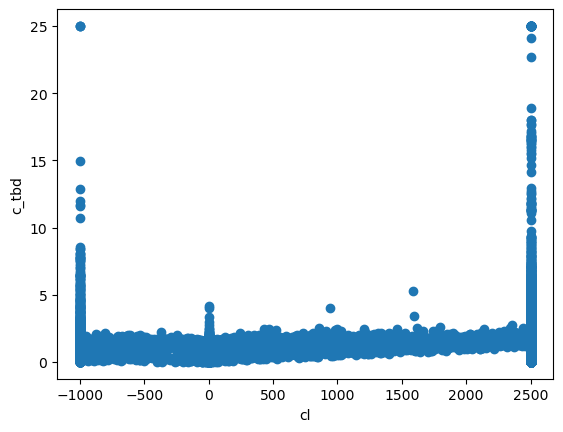

In [240]:
alph = SEB.find_alpha(SEBdata)

In [241]:
alph

260.20083022134935

In [242]:
df = pd.DataFrame(melt_dict_fluxes)
df.head(10)

,Melt,Res,T_surf,LW_adj_up,LW_adj_down,SHF_adj,LHF_adj
0,1.428001,0.0,268.601708,-295.132759,155.9,-58.048492,0.000000
1,1.080767,0.0,260.439900,-260.863087,161.1,-19.961071,0.000000
2,1.179884,0.0,257.498650,-249.277065,165.0,-14.920206,0.000000
3,1.053739,0.0,255.580193,-241.930915,168.8,-12.603998,0.000000
4,0.815359,0.0,254.069254,-236.260544,173.4,-11.025527,0.000000
5,0.893226,0.0,252.569867,-230.732552,175.1,-12.993404,-0.005751
6,0.882305,0.0,251.638238,-227.347024,174.6,-13.332476,-0.009285
7,1.185149,0.0,252.990351,-232.272827,172.4,-31.475407,-0.010373
8,1.360870,0.0,252.728503,-231.312651,172.9,-31.441174,-0.011869
9,1.281882,0.0,252.628286,-230.945993,174.1,-23.812165,-0.022653


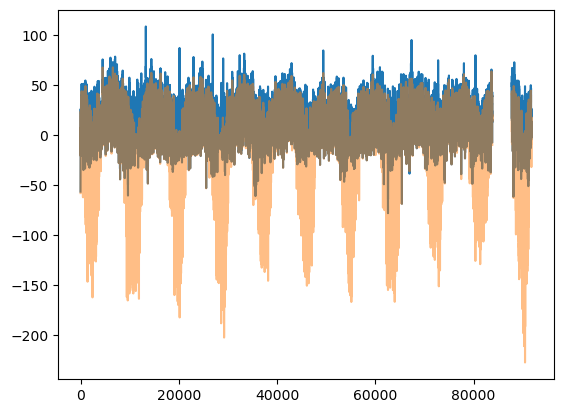

In [243]:
plt.plot(SEB.SHF_initial)
plt.plot(melt_dict_fluxes['SHF_adj'], alpha=0.5)
# TODO: something is wrong with SHF_adj

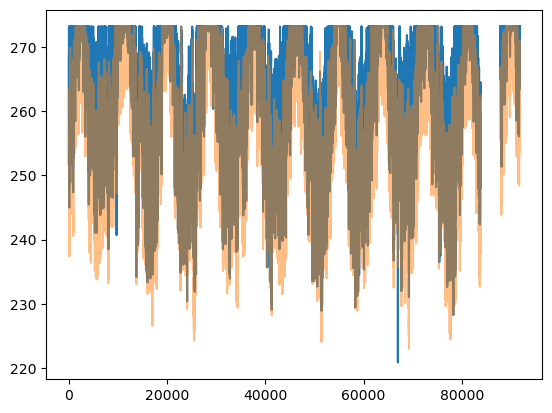

In [244]:
plt.plot(melt_dict_fluxes['T_surf'])
plt.plot(SEB.T_surface, alpha=0.5)

# TODO: T_surf seems to be not properly restricted to 0 degC! That might fuck up everything

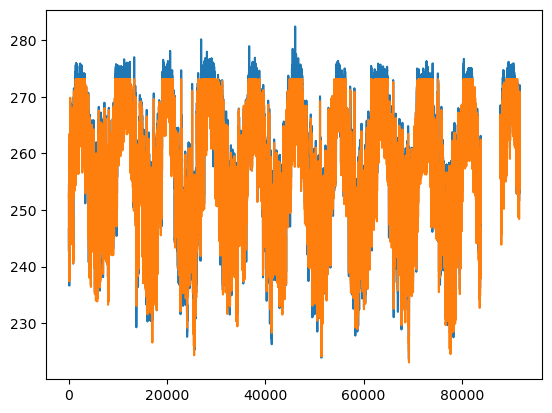

In [245]:
plt.plot(SEB.T_air)
plt.plot(SEB.T_surface)

In [246]:
netLW = [i + j for i, j in zip(melt_dict_fluxes['LW_adj_up'], melt_dict_fluxes['LW_adj_down'])]

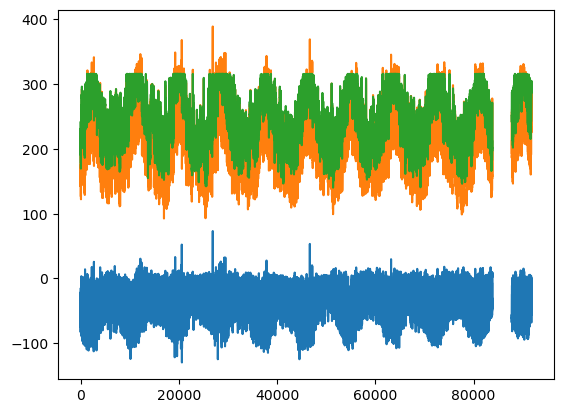

In [247]:
plt.plot(SEB.LWnet_model)
plt.plot(SEB.LWdown)
plt.plot(SEB.LWup)

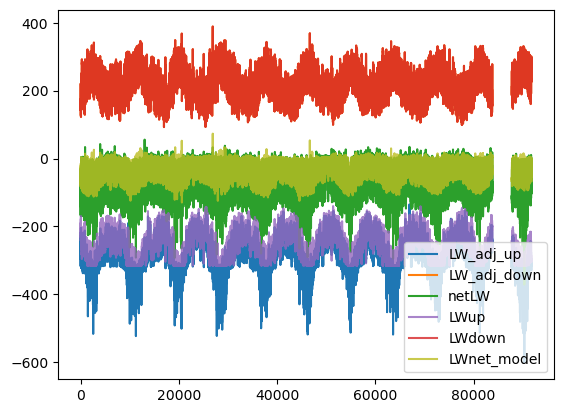

In [248]:
plt.plot(melt_dict_fluxes['LW_adj_up'], label='LW_adj_up', color='tab:blue')
plt.plot(melt_dict_fluxes['LW_adj_down'], label='LW_adj_down', color='tab:orange')
plt.plot(netLW, label='netLW', color='tab:green')

plt.plot(-SEB.LWup, color='tab:purple', label='LWup', alpha=0.8)
plt.plot(SEB.LWdown, color='tab:red', label='LWdown', alpha=0.8)
plt.plot(SEB.LWnet_model, color='tab:olive', label='LWnet_model', alpha=0.8)

plt.legend()
# TODO: something is wrong with LWadjup

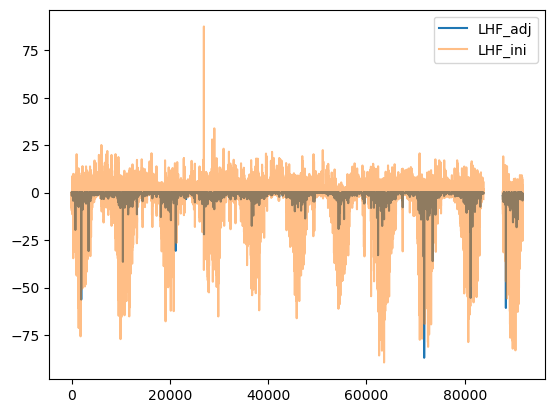

In [249]:
plt.plot(melt_dict_fluxes['LHF_adj'], label='LHF_adj')
plt.plot(SEB.LHF_initial, label='LHF_ini', alpha=.5)
plt.legend()
# TODO: something is wrong with LHF

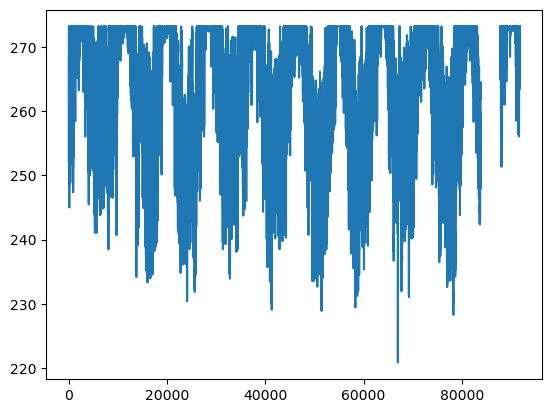

In [250]:
plt.plot(melt_dict_fluxes['T_surf'])
# plt.axhline(273.15, color='r', linestyle='--')

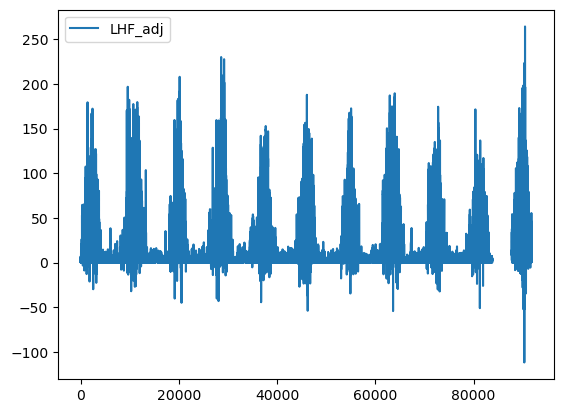

In [251]:
plt.plot(melt_dict_fluxes['Melt'], label='LHF_adj')
# plt.plot(SEB.LHF_initial, label='LHF_initial', alpha=.5)
plt.legend()

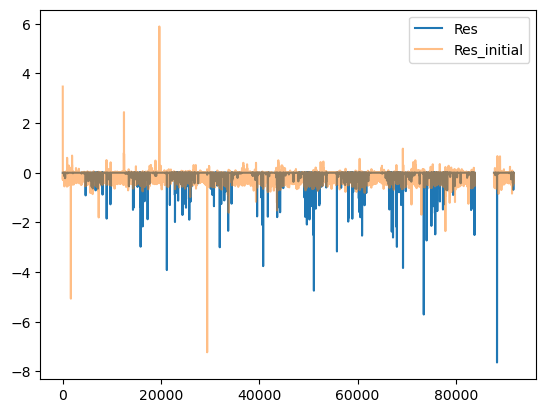

In [252]:
# plt.plot(melt_dict_fluxes['Melt'], label='Melt')
# plt.plot(SEB.melt_initial, label='Melt_initial', alpha=.5)

plt.plot(melt_dict_fluxes['Res'], label='Res')
plt.plot(SEB.res_initial, label='Res_initial', alpha=.5)
plt.legend()

In [253]:
class FluxPlotter():
    def __init__(self,SEBdata):
        self.SEBdata = SEBdata


    def plot_fluxes(self, SHF,SWdown,SWup,SWnet,LWdown,LWup,LWnet,LHF,Gs,MeltS,Residu):
        PlotType = "Monthly"
        MyFunc = SEBf.get_monthly_average
        Range  = [self.SEBdata.DateTime[0], self.SEBdata.DateTime[-1]]
        Label  = "Year"

        Xdata  = MyFunc(SHF, self.SEBdata.DateTime, GiveDatesBack=True)[1]

        MonthSWdownS = MyFunc(SWdown, self.SEBdata.DateTime, PrintInfo=True)
        MonthSWupS   = MyFunc(SWup, self.SEBdata.DateTime)
        MonthSHFS    = MyFunc(SHF, self.SEBdata.DateTime)

        fig, axs = plt.subplots(2, sharex=True)
        # upper figure are the radiative fluxes
        axs[0].plot(Xdata, MonthSWdownS, 'b', linewidth=0.5, label="$SW_{down}$")
        axs[0].plot(Xdata, -MonthSWupS, 'b:', linewidth=0.5, label="$SW_{up}$")
        axs[0].plot(Xdata, MyFunc(LWdown, self.SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{down}$")
        axs[0].plot(Xdata, MyFunc(-LWup, self.SEBdata.DateTime), 'r:', linewidth=0.5, label="$LW_{up}$")
        axs[0].plot(Xdata, MyFunc(SWnet+LWnet, self.SEBdata.DateTime), 'k', linewidth=0.5, label="$R_{net}$")
        axs[0].set_ylabel("Energy flux (W/m2)")
        axs[0].legend(loc='lower right') # well, no spot is nice
        axs[0].grid(True)

        axs[1].plot(Xdata, MyFunc(SWnet, SEBdata.DateTime), 'b', linewidth=0.5, label="$SW_{net}$")
        axs[1].plot(Xdata, MyFunc(LWnet, self.SEBdata.DateTime), 'r', linewidth=0.5, label="$LW_{net}$")
        axs[1].plot(Xdata, MyFunc(SHF, self.SEBdata.DateTime), 'seagreen', linewidth=0.5, label="$SHF$")
        axs[1].plot(Xdata, MyFunc(LHF, self.SEBdata.DateTime), 'orange', linewidth=0.5, label="$LHF$")
        axs[1].plot(Xdata, MyFunc(Gs, self.SEBdata.DateTime), 'grey', linewidth=0.5, label="$Gs$")
        axs[1].plot(Xdata, MyFunc(MeltS, self.SEBdata.DateTime), 'purple', linewidth=0.5, label="$M$")
        axs[1].plot(Xdata, MyFunc(Residu, self.SEBdata.DateTime), 'k', linewidth=0.5, label="Res")

        axs[1].set_ylabel("Energy flux (W/m2)")
        axs[1].legend(loc='lower right') # Again, no spot is nice
        axs[1].set_xlabel(Label)
        axs[1].set_xlim(Range)
        axs[1].grid(True)



The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.
The date and hour of the first entry is April 05, 2009, 00:00.
First full month starts at May 01, 2009, 00:00
The date and hour of the last entry is September 23, 2019, 23:00.
Last full month end at August 31, 2019, 23:00
The dataset contains data of 125 months.


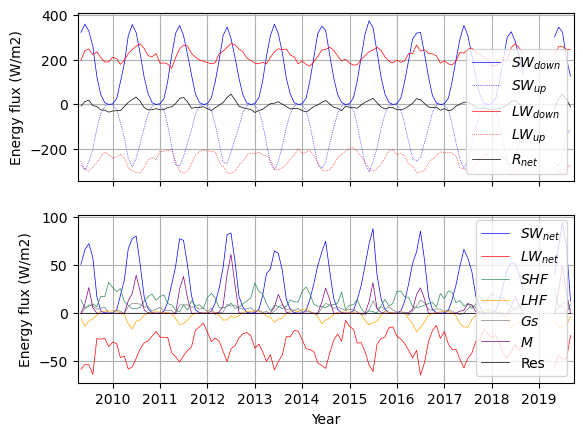

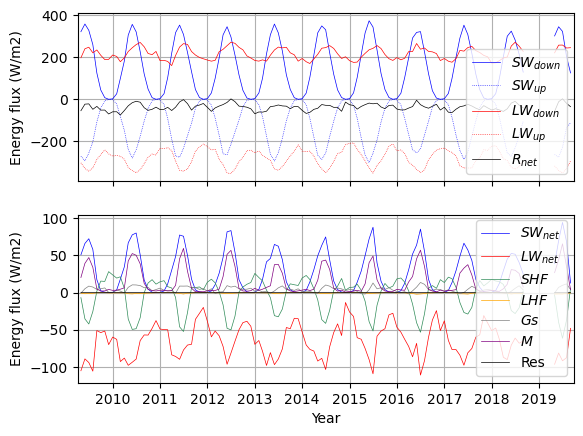

In [254]:
plotter = FluxPlotter(SEBdata)
plotter.plot_fluxes(SHF=SEB.SHF_initial,SWdown=SEB.SWdown,SWup=SEB.SWup,SWnet=SEB.SWnet,LWdown=SEB.LWdown,LWup=SEB.LWup,LWnet=SEB.LWnet_model,LHF=SEB.LHF_initial,Gs=SEB.G,MeltS=SEB.melt_initial,Residu=SEB.res_initial)
plotter.plot_fluxes(SHF=melt_dict_fluxes['SHF_adj'], SWdown=SEB.SWdown,SWup=SEB.SWup,SWnet=SEB.SWnet,LWdown=melt_dict_fluxes['LW_adj_down'], LWup=-1*np.array(melt_dict_fluxes['LW_adj_up']),LWnet=netLW,LHF=melt_dict_fluxes['LHF_adj'],Gs=SEB.G,MeltS=melt_dict_fluxes['Melt'],Residu=melt_dict_fluxes['Res'])


In [235]:
dT = 0
SEB = CloseSEB(SEBdata)
LWadjdown = SEB.LWadjdown(SEB.T_air, dT=dT)
# TODO: in the beginning we get LWdown by air temperature and without epsilon, but later we calculate it with T2m and with epsilon
melt_dict_fluxes = SEB.fetch_SEB(LWadjdown=LWadjdown, dT=dT)

C:\Users\lasse\AppData\Local\Temp\ipykernel_16328\1418310682.py:30: RuntimeWarning: divide by zero encountered in divide
  c_tbd = np.array(SHF)/(self.U10* (np.array(T_air2m) - np.array(T_surf)))


,Melt,Res,T_surf,LW_adj_up,LW_adj_down,SHF_adj,LHF_adj
0,1.428001,0.0,268.601708,-295.132759,155.9,-58.048492,0.000000
1,1.080767,0.0,260.439900,-260.863087,161.1,-19.961071,0.000000
2,1.179884,0.0,257.498650,-249.277065,165.0,-14.920206,0.000000
3,1.053739,0.0,255.580193,-241.930915,168.8,-12.603998,0.000000
4,0.815359,0.0,254.069254,-236.260544,173.4,-11.025527,0.000000
...,...,...,...,...,...,...,...
91771,25.958420,0.0,273.160000,-316.770991,280.6,-4.149165,-3.694399
91772,7.552239,0.0,273.160000,-315.761261,287.1,10.584637,-2.459727
91773,1.722914,0.0,272.403764,-312.201664,291.9,13.576897,-2.131528
91774,1.799559,0.0,272.110550,-310.859602,290.8,12.820232,-2.198129
